# Быстрый инференс LLM

Почему LLM работают долго? Главная проблема - квадратичная сложность внимания (для каждого токена из последовательности нужно получить attention score для всех других токенов). Поэтому нужно много вычислять.

## Меняем представление внимания. От Multi-head attention к Group Query Attention.

Идея: давайте для каждой головы **не использовать** свои матрицы W_Q, W_K, а как-то и унифицировать.

**Multi-Query Attention (MQA)** - в каждой голове используем свою матрицу Q, но одну и ту же матрицу K и V.

https://arxiv.org/pdf/1911.02150

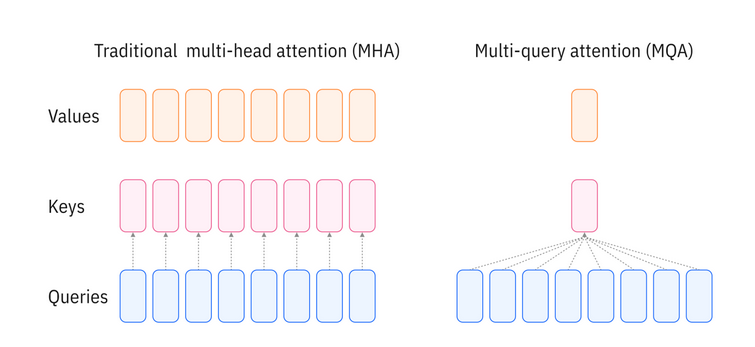


Промежуточное решение - **Group-Query Attention (GQA)** - храним общие матрицы K и V для группы голов.

Статья: https://arxiv.org/pdf/2305.13245

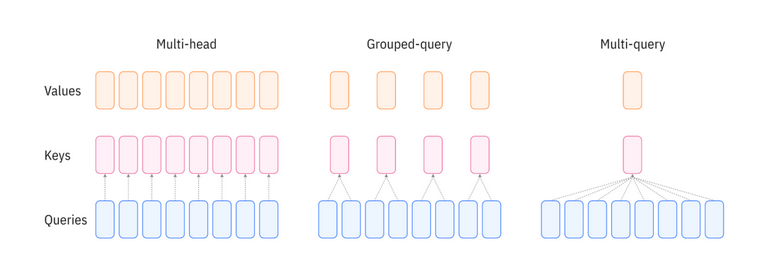

---

## Flash Attention

Как оптимизировать вычисления? На помощь приходит популярный ныне Flash Attention.

Пиковое потребление памяти GPU слоями самовнимания растёт квадратично (по длине последовательности) как по временной сложности, так и по количеству памяти.

Формула для вычисления выхода $\mathbf{O}$ слоя самовнимания для входа $\mathbf{X}$ длиной $N$ выглядит так:

$$ \textbf{O} = \text{Attn}(\mathbf{X}) = \mathbf{V} \times \text{Softmax}(\mathbf{QK}^T) \text{, где } \mathbf{Q} = \mathbf{W}_q \mathbf{X}, \mathbf{V} = \mathbf{W}_v \mathbf{X}, \mathbf{K} = \mathbf{W}_k \mathbf{X} $$

При этом $\mathbf{X} = (\mathbf{x}_1, ... \mathbf{x}_{N})$ представляет собой входную последовательность для слоя внимания. Проекции $\mathbf{Q}$ и $\mathbf{K}$ будут состоять из $N$ векторов каждый, в результате чего матрица $\mathbf{QK}^T$ будет иметь размер $N^2$, где $N$ - длина входной последовательности.

Так же держим в голове, что LLM используют несколько голов внимания.
Предположим, что LLM имеет 40 голов внимания и работает в bfloat16. Требования к памяти для хранения матриц $\mathbf{QK^T}$ = $40 * 2 * N^2$ байт. Для $N=1000$ требуется всего около 50 МБ видеопамяти, однако для $N=16000$ нам уже потребовалось бы 19 ГБ, а для $N=100,000$ — почти 1 ТБ только для хранения матриц $\mathbf{QK}^T$.

Короче говоря, стандартный алгоритм самовнимания быстро становится дорогим с точки зрения памяти для большого контекста.

Как можно избавиться от непомерных требований к памяти для больших входных длин? Нам нужен новый способ вычисления механизма самовнимания, который исключает необходимость в матрице $QK^T$. [Три Дао и др.](FlashAttention:%20Fast%20and%20Memory-Efficient%20Exact%20Attention%20with%20IO-Awareness) разработали именно такой алгоритм и назвали его **Flash Attention**.

В двух словах, Flash Attention использует свойство умножения блочных матриц (подробнее здесь https://mathworld.wolfram.com/BlockMatrix.html), разбивает вычисление $ \mathbf{V} \times \text{Softmax}(\mathbf{QK}^T) $ на части и вместо этого вычисляет меньшие фрагменты вывода, итерируя по нескольким шагам вычисления softmax:

$$ \textbf{O}_i \leftarrow s^a_{ij} * \textbf{O}_i + s^b_{ij} * \mathbf{V}_{j} \times \text{Softmax}(\mathbf{QK}^T_{i,j}) \text{ для нескольких итераций } i, j $$

где $s^a_{ij}$ и $s^b_{ij}$ — это некоторые статистики нормализации softmax, которые необходимо пересчитывать для каждой пары $i$ и $j$.


> Самое важное преимущество заключается в том, что все эти блоки можно загрузить в быструю SRAM и там посчитать.

Ключевой вывод здесь следующий:

> Flash Attention даёт **численно идентичный** результат по сравнению со стандартным слоем самовнимания при стоимости памяти, которая растёт лишь линейно с $N$.

Глядя на формулу, можно интуитивно предположить, что Flash Attention должен работать значительно медленнее по сравнению со стандартной формулой самовнимания, поскольку требуется больше вычислений. Это действительно так, потому что статистики нормализации softmax приходится постоянно пересчитывать (подробнее см. [статью](https://arxiv.org/pdf/2205.14135.pdf), если интересно).

> Однако Flash Attention все равно работает намного быстрее по сравнению со стандартным вниманием благодаря своей способности использовать SRAM.



Еще более упрощенный алгоритм:
1. Делим матрицы K и V на блоки.
2. Загружаем блоки в быструю память (SRAM)
3. Перемножаем там.
4. Считаем


Чуть более детальное объяснение: https://habr.com/ru/articles/669506/

---

## А что дальше? Используем кеш!

Вспомним, как происходит генерация. Перед предсказанием нового токена, мы считаем внимание. Потом семплируем новый токен. Потом считаем внимание для дополненной последовательности. Потом семплируем токен... Чуете что-то неладное?

Мы много раз пересчитываем внимание между одними и теми же токенами.
Поэтому предложение - давайте ничего не пересчитывать, а хранить значения q, k, v для уже "просмотренных" токенов в кеше.

Детали с huggingface: https://huggingface.co/blog/kv-cache

---

## Можно ли что-то ещё улучшить? Да, ведь фрагментация неизбежна :(

### Упрощенное объяснение "на пальцах"

Пусть на запрос №1 нам нужно 10 Мб видеопамяти, на запрос №2 - 5 мб, на запрос №3 - 15 мб и 5 мб на №4 запрос. Схематично обозначим вот так (для упрощения визуализации скажем, это у нас вся свободная память):

```
|==========|=====|===============|=====|

  Запрос 1  Зап.2   Запрос 3      Зап. 4

```

Допустим, генерация для первого и четвертого запроса завершилась. Мы освобождаем память. Что получается:

```
|----------|=====|===============|-----|

  Свободно  Зап.2   Запрос 3      Свободно

```

Итого у нас свободно 15 мб видеопамяти.

К нам приходит новый запрос и на него требуется под кеш отдать 13 мб памяти. Сможем ли мы это сделать? Нет. Хотя свободной памяти у нас больше, но, к сожалению, она фрагментирована.


Что можно сделать? Давайте хранить кеш не последовательно, а блоками. Т.е. если у нас был массив длинной $N$, мы можем его на блоки размером k, и в память сохранять блоки этого вектора. Тогда нашу память под запрос в 13 мб можем разбить вот так (если взять блок размером 3 мб):
```
|[1][2][3]-|=====|===============|[4][5]-|

  Нов.зап.1  Зап.2   Запрос 3      Нов.зап. 1

```

Конечно, мы отдельно храним таблицу, в которой записано, какие блоки к какому запросу относятся.

Этот подход называется [Paged Attention](https://arxiv.org/pdf/2309.06180). На блоки мы бьем кеш.






#### Визуализация из статьи
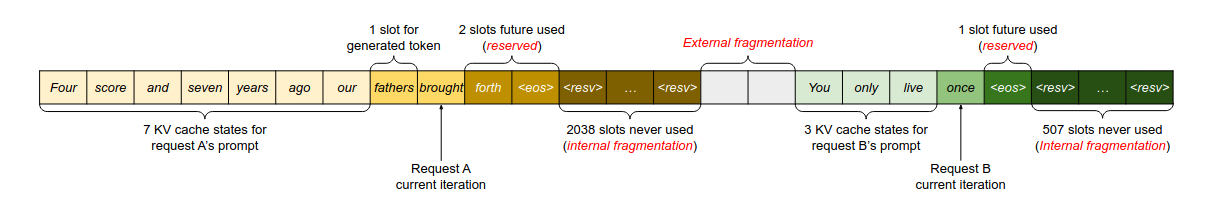



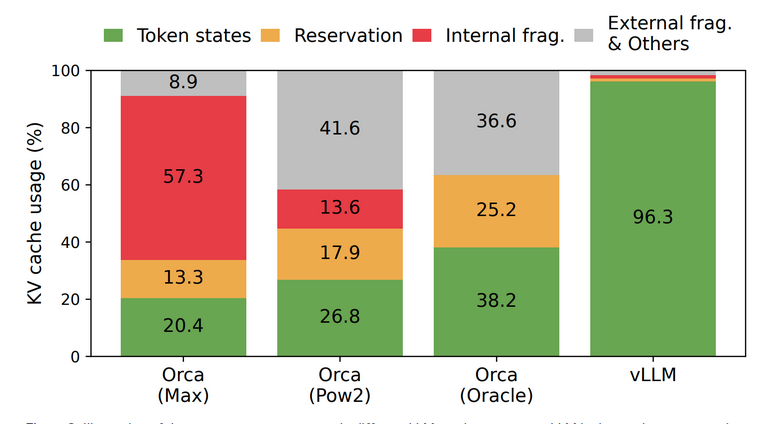

## А как делать быстрый инференс LLM на практике? VLLM!

vLLM — это высокопроизводительный движок для инференса больших языковых моделей, разработанный в UC Berkeley. Собственно, для этого движка и придумали механизм PagedAttention.

Git: https://github.com/vllm-project/vllm

Docs: https://docs.vllm.ai

In [ ]:
!pip install vllm==0.7.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 

In [ ]:
from vllm import LLM, SamplingParams

# Параметры семплинга — управляют генерацией
sampling_params = SamplingParams(
    temperature=0.7,
    top_p=0.9,
    max_tokens=256
)

# Инициализация движка vLLM
llm = LLM(
    model="meta-llama/Llama-3-8B-Instruct",
    tensor_parallel_size=1,                  # число GPU, участвующих в параллелизме по тензорам
    gpu_memory_utilization=0.9,              # доля GPU памяти, доступная под модель
    max_model_len=4096,                      # максимальная длина контекста
    enforce_eager=False,                     # использовать компиляцию CUDA-графов
)

# Пример генерации
output = llm.generate(
    ["Что такое PagedAttention?"],
    sampling_params
)
print(output[0].outputs[0].text)


### Сравним скорость transformers и vllm

Иногда vllm в colab зависает, в таком случае можно будет перезапустить сессию.

In [ ]:
MODEL_NAME = "Qwen/Qwen2.5-3B-Instruct"
PROMPTS = [
    "Explain the concept of attention in transformers.",
    "Write a short story about a robot learning emotions.",
    "What are the key differences between GPT and BERT?",
    "Describe how vLLM speeds up inference for LLMs.",
] * 100

MAX_NEW_TOKENS = 256
DEVICE = "cuda"

In [ ]:
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from openai import OpenAI
from tqdm import tqdm


tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto"
)
model.eval()


In [ ]:
start = time.time()
inputs = tokenizer(PROMPTS, return_tensors="pt", padding=True, truncation=True).to(DEVICE)
_ = model.generate(**inputs, max_new_tokens=MAX_NEW_TOKENS)
end = time.time()
print(f"{end - start} s")

In [ ]:
import torch, gc

del model, inputs
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()


In [ ]:
from vllm import LLM, SamplingParams

sampling_params = SamplingParams(temperature=0.7, max_tokens=MAX_NEW_TOKENS)
llm = LLM(model=MODEL_NAME, dtype="float16", gpu_memory_utilization=0.9)

INFO 10-29 17:02:37 __init__.py:207] Automatically detected platform cuda.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


WARNING 10-29 17:02:39 config.py:2448] Casting torch.bfloat16 to torch.float16.
INFO 10-29 17:02:55 config.py:549] This model supports multiple tasks: {'score', 'classify', 'embed', 'generate', 'reward'}. Defaulting to 'generate'.
INFO 10-29 17:02:55 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='Qwen/Qwen2.5-3B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2.5-3B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_exe

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 10-29 17:03:34 model_runner.py:1115] Loading model weights took 5.7915 GB
INFO 10-29 17:03:43 worker.py:267] Memory profiling takes 8.64 seconds
INFO 10-29 17:03:43 worker.py:267] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.90) = 13.27GiB
INFO 10-29 17:03:43 worker.py:267] model weights take 5.79GiB; non_torch_memory takes 0.05GiB; PyTorch activation peak memory takes 2.52GiB; the rest of the memory reserved for KV Cache is 4.90GiB.
INFO 10-29 17:03:43 executor_base.py:111] # cuda blocks: 8928, # CPU blocks: 7281
INFO 10-29 17:03:43 executor_base.py:116] Maximum concurrency for 32768 tokens per request: 4.36x
INFO 10-29 17:03:47 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_util

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:34<00:00,  1.00it/s]

INFO 10-29 17:04:22 model_runner.py:1562] Graph capturing finished in 35 secs, took 0.21 GiB
INFO 10-29 17:04:22 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 48.04 seconds


In [ ]:
import time


start = time.time()
output = llm.generate(PROMPTS, sampling_params)
end = time.time()
print(f"{end - start} s")

Processed prompts: 100%|██████████| 400/400 [01:00<00:00,  6.62it/s, est. speed input: 72.83 toks/s, output: 1676.63 toks/s]

60.525421142578125 s


In [ ]:
import torch, gc

del llm, output
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()


## Что еще можно посмотреть?

1. [Linformer](https://arxiv.org/pdf/2006.04768) - матрицы W_K, W_Q - низкоранговые, поэтому их можно спроецировать в пространство меньшей размерности и не потерять в качестве.

2. [Sparse Attention](https://arxiv.org/pdf/1904.10509) - считаем attention не по всем токенам, а только внутри какой-то группы.

При реализации Sparse attention можно использовать различные подходы. Один из них заключается в том, чтобы разбить последовательность на блоки и вычислять внимание только между элементами внутри каждого блока и между элементами разных блоков.

Другой подход — выбор наиболее важных элементов в последовательности на основании их сходства. Для этого могут применяться различные методы кластеризации.

Третий подход заключается в использовании различных эвристик и алгоритмов для выбора наиболее важных элементов в последовательности, например, на основе их частотности, значимости или контекста.

3. [llama.cpp](https://github.com/ggml-org/llama.cpp) - еще один движок для инференса.